In [1]:
import numpy as np
from pathlib import Path
import Visualisation_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from active_learning import get_high_variance_cells

LOG_DIR = Path("log/active_learning/AL: testing")


In [2]:
with np.load(LOG_DIR / '0' / 'train' / 'val_predictions.npz') as npz_file:
    predict_points = npz_file['points']
    predict_preds = npz_file['preds']
    predict_target = npz_file['target']
    predict_variance = npz_file['variance']  # Variances are normalised to [-1,1]
    predict_point_variance = npz_file['point_variance']
    predict_grid_mask = npz_file['grid_mask']
    predict_features = npz_file['features']
    predict_samples_per_cell = npz_file['samples_per_cell']

In [3]:
cell_centers = np.array(
    [np.mean(predict_points[np.where(predict_grid_mask == i)[0], :3], axis=0) for i in range(len(predict_variance))])

In [4]:
a = np.array([[0, 10], [1, 11], [2, 12]])
print(a.shape)
np.mean(a, axis=0)

(3, 2)


array([ 1., 11.])

(-10.0, 20.0)

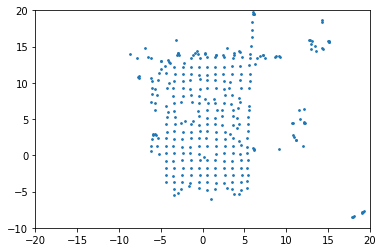

In [5]:
plt.scatter(cell_centers[:, 0], cell_centers[:, 1], s=3)
plt.xlim(-20, 20)
plt.ylim(-10, 20)

In [6]:
variance_ordering_idxs = predict_variance.argsort()[::-1]
num_cells = 10

In [7]:
import matplotlib.pyplot as plt
from sklearn import cluster

In [8]:
kmeans = cluster.KMeans(n_clusters=num_cells, random_state=0).fit(predict_features)

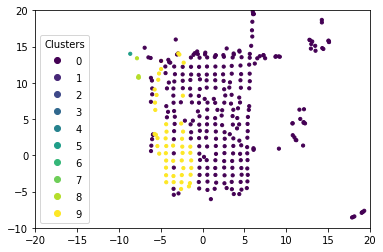

In [9]:
fig, ax = plt.subplots()
scatter = ax.scatter(cell_centers[:, 0], cell_centers[:, 1], c=kmeans.labels_, s=10)
plt.xlim(-20, 20)
plt.ylim(-10, 20)

# add legend to plt
ax.legend(*scatter.legend_elements(), loc="lower left", title="Clusters")
plt.show()

# Finding the optimal K
## Elbow Method

In [30]:
from sklearn.cluster import KMeans
from scipy.spatial import distance


# function returns WSS score for k values from 1 to kmax


def calculate_WSS(points, kmax, kmin=1, ax=None):
    sse = []
    for idx, k in tqdm(enumerate(range(kmin, kmax + 1))):
        kmeans = KMeans(n_clusters=k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        if ax is not None:
            ax[1, idx].scatter(cell_centers[:, 0],
                               cell_centers[:, 1], c=kmeans.labels_, s=10)
            ax[1, idx].set_xlim(-20, 20)
            ax[1, idx].set_ylim(-10, 20)
            ax[1, idx].set_title("k = %d" % k)

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += distance.cosine(points[i], curr_center)

        sse.append(curr_sse)
    return sse


fig, ax = plt.subplots(2, 1, figsize=(50, 10))
ax[0].set_title('square euclidean')
ax[0].set_ylabel('WSS')
ax[0].set_xlabel('Number of clusters')
ax[0].plot(np.arange(1, 10), calculate_WSS(predict_features, 10, 1))

ax[1].set_title('Cosine')
ax[1].set_ylabel('WSS')
ax[1].set_xlabel('Number of clusters')
ax[1].plot(np.arange(1, 10), calculate_WSS(predict_features, 10, 1))

TypeError: __init__() got an unexpected keyword argument 'fig_size'

## Silhouette Method

100%|██████████| 9/9 [00:00<00:00, 10.92it/s]


sqeuclidean: [5 7 6 4 2 3]
cosine: [8 0 3 2 6 4]


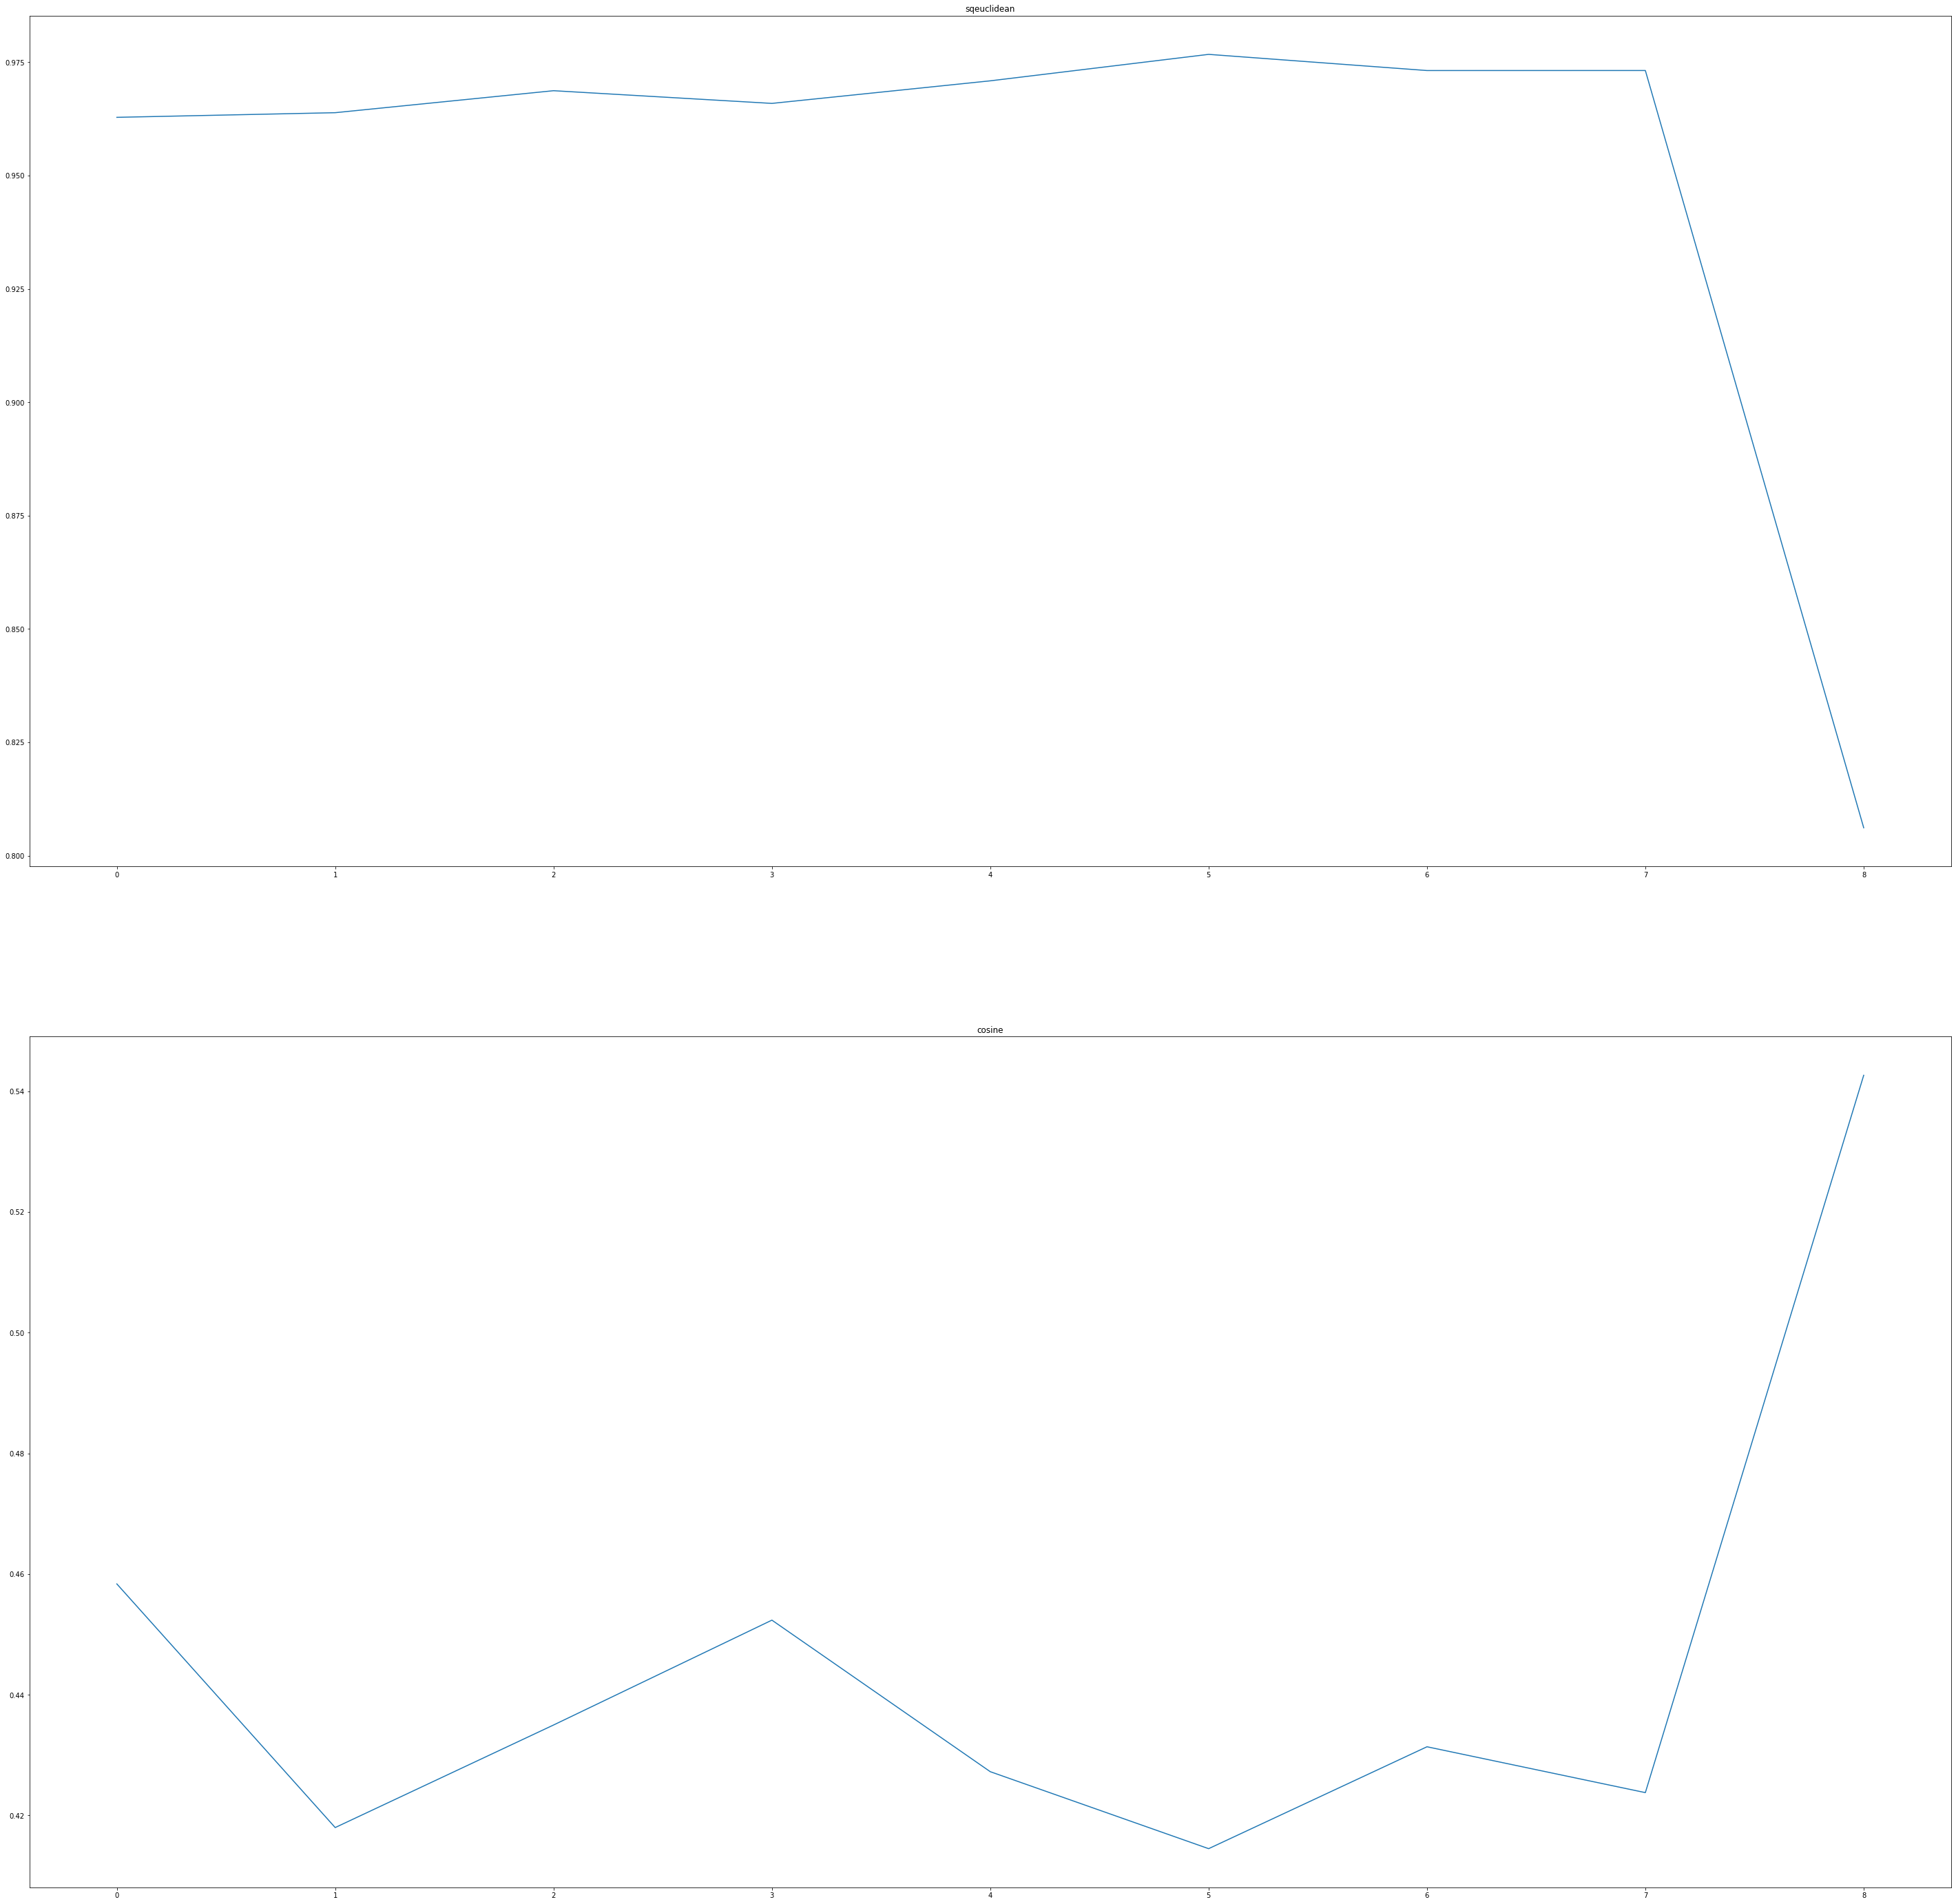

In [33]:
from sklearn.metrics import silhouette_score

sil = [[], []]
elbow = [[], []]
kmax = 10
distances = ['sqeuclidean', 'cosine']

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax + 1)):
    kmeans = KMeans(n_clusters=k).fit(predict_features)
    labels = kmeans.labels_
    for idx, dist in enumerate(distances):
        sil[idx].append(silhouette_score(predict_features, labels, metric=dist))

fig, ax = plt.subplots(2, 1, figsize=(50, 20))
for i in range(2):
    ax[i].plot(sil[i])
    ax[i].set_title(distances[i])
    print(f"{distances[i]}: {np.argsort(sil[i])[:-7:-1]}")

# ReDAL
Score each sample with its uncertainty U

Clusters the samples into K clusters based on their feature embeddings

Sort the regions based on the uncertainty U

For each region, penalise the scores of the remaining regions in that cluster by some factor P

The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).

In [ ]:
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {predict_variance[idx]:.4f} ")

In [ ]:
penalty_factor = 0.9
adjusted_variance = np.copy(predict_variance)
for i, idx in enumerate(variance_ordering_idxs):
    current_cluster = kmeans.labels_[idx]
    for x in range(i + 1, len(variance_ordering_idxs)):
        x = variance_ordering_idxs[x]
        if kmeans.labels_[x] == current_cluster:
            adjusted_variance[x] *= penalty_factor

print(f"Old variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
adjusted_variance_ordering_idxs = adjusted_variance.argsort()[::-1]
print(f"New variance_ordering_idxs:\n{adjusted_variance_ordering_idxs[:10]}")
for idx in adjusted_variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {adjusted_variance[idx]:.4f}")